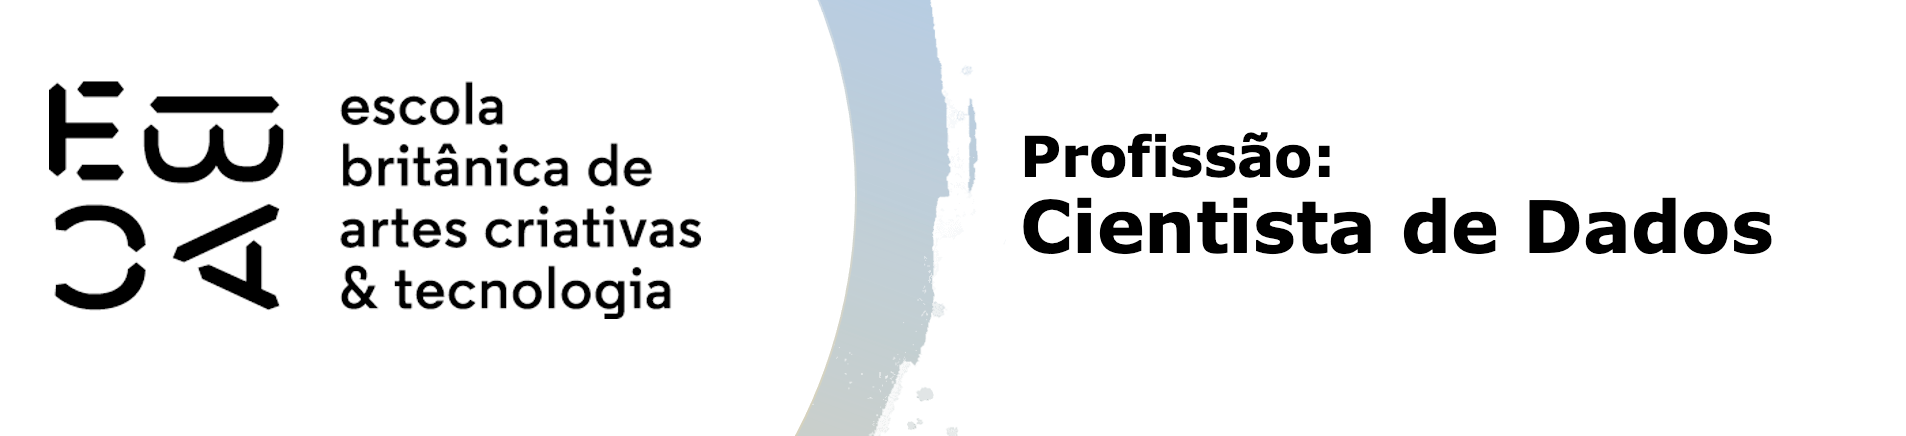

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_dados = pd.read_pickle('base_nfp.pkl')
base_dados.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [4]:
# Filtrar os dados a partir de janeiro de 2020
base_dados['Data Emissão'] = pd.to_datetime(base_dados['Data Emissão'])
dados_filtrados = base_dados[base_dados['Data Emissão'] >= '2020-01-01']

# Analisar a proporção de notas que tiveram retorno maior que 0 por categoria de estabelecimento
proporcao_retorno = (
    dados_filtrados[dados_filtrados['Retorno'] > 0]
    .groupby('categoria')
    .size() / dados_filtrados.groupby('categoria').size()
).reset_index(name='Proporção de Notas com Retorno')

# Exibir a tabela com a proporção
proporcao_retorno.sort_values(by='Proporção de Notas com Retorno', ascending=False)

,categoria,Proporção de Notas com Retorno
5,Restaurantes,0.746214
0,Alimentos,0.681584
4,Mercado,0.478155
2,Construção,0.468810
8,não definido,0.363394
3,Farmácia,0.351556
1,Auto posto,0.250000
7,Vestuário,0.230729
6,Varejo,0.138373


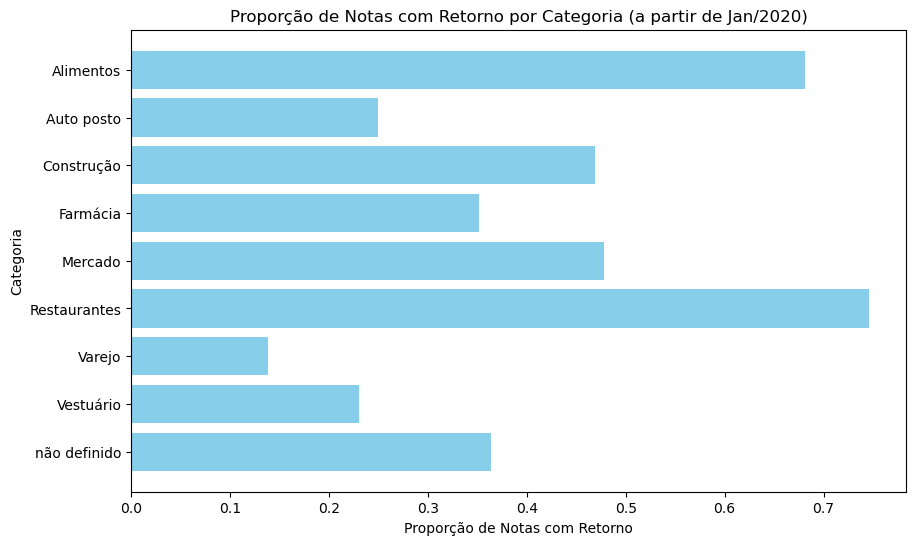

In [5]:
import matplotlib.pyplot as plt

# Criar o gráfico de barras para a proporção de notas com retorno por categoria
plt.figure(figsize=(10, 6))
plt.barh(proporcao_retorno['categoria'], proporcao_retorno['Proporção de Notas com Retorno'], color='skyblue')
plt.xlabel('Proporção de Notas com Retorno')
plt.ylabel('Categoria')
plt.title('Proporção de Notas com Retorno por Categoria (a partir de Jan/2020)')
plt.gca().invert_yaxis()  # Inverte a ordem das categorias para que as maiores apareçam no topo
plt.show()

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [7]:
# Calcular a proporção de notas com retorno > 0 (evento) e retorno = 0 (não evento) por categoria
total_evento = dados_filtrados[dados_filtrados['Retorno'] > 0].shape[0]
total_nao_evento = dados_filtrados[dados_filtrados['Retorno'] == 0].shape[0]

proporcao_evento = dados_filtrados[dados_filtrados['Retorno'] > 0].groupby('categoria').size() / total_evento
proporcao_nao_evento = dados_filtrados[dados_filtrados['Retorno'] == 0].groupby('categoria').size() / total_nao_evento

# Calcular o WOE (Weight of Evidence) para cada categoria
woe = np.log(proporcao_evento / proporcao_nao_evento).reset_index(name='WOE').fillna(0)

# Exibir o WOE calculado
woe.sort_values(by='WOE', ascending=False)

,categoria,WOE
5,Restaurantes,1.344354
0,Alimentos,1.026895
4,Mercado,0.178746
2,Construção,0.141265
8,não definido,-0.289780
3,Farmácia,-0.346375
1,Auto posto,-0.832779
7,Vestuário,-0.934974
6,Varejo,-1.336733


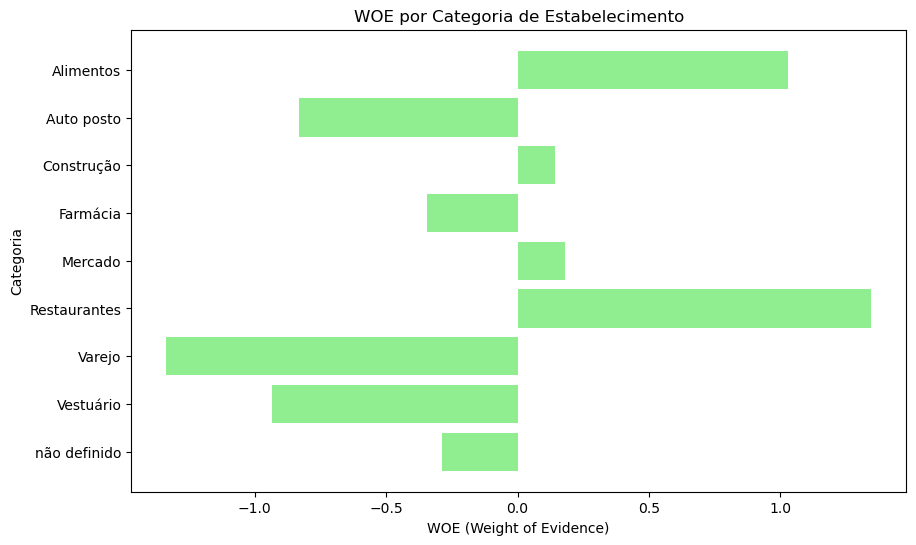

In [8]:
# Criar o gráfico de barras para o WOE por categoria
plt.figure(figsize=(10, 6))
plt.barh(woe['categoria'], woe['WOE'], color='lightgreen')
plt.xlabel('WOE (Weight of Evidence)')
plt.ylabel('Categoria')
plt.title('WOE por Categoria de Estabelecimento')
plt.gca().invert_yaxis()  # Inverter a ordem das categorias para que as maiores apareçam no topo
plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [10]:
# Calcular o Information Value (IV)
woe['IV'] = (proporcao_evento - proporcao_nao_evento).values * woe['WOE']

# Somar os IVs de todas as categorias para obter o IV total da variável
information_value = woe['IV'].sum()

information_value

0.24096448519764424

## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


A análise mostrou que categorias como Restaurantes e Alimentos têm uma alta propensão a fornecer créditos, enquanto Varejo e Vestuário têm uma propensão significativamente menor. O Information Value (IV) de 0,241 indica que a categoria de estabelecimento é uma variável de poder preditivo moderado na previsão de crédito das notas fiscais.